In [1]:
from lcdb.db import LCDB
from lcdb.analysis.util import LearningCurve, LearningCurveGroup, LearningCurveExtractor, merge_curves

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
workflows = [
    "lcdb.workflow.sklearn.KNNWorkflow",
    "lcdb.workflow.sklearn.LibLinearWorkflow",
    "lcdb.workflow.sklearn.LibSVMWorkflow",
    "lcdb.workflow.sklearn.TreesEnsembleWorkflow"
]

openmlid = 11
workflow = workflows[1]

# retrieve learning curve objects
lcdb = LCDB()
df_full = lcdb.query(
    openmlids=[openmlid],
    workflows=[workflow],
    test_seeds=[0],
    return_generator=False,
    processors={
        "learning_curve": LearningCurveExtractor(
            metrics=["error_rate"],
            folds=["train", "val"]
        )
    },
    show_progress=True
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.50s/it]


In [3]:
# group by configurations
config_cols = [c for c in df_full.columns if c.startswith("p:")]
df_grouped = df_full.groupby(config_cols).agg({"learning_curve": merge_curves})

In [4]:
df_grouped["learning_curve"]

p:C           p:class_weight  p:dual  p:fit_intercept  p:intercept_scaling  p:loss         p:max_iter  p:multiclass  p:penalty  p:pp@cat_encoder  p:pp@decomposition  p:pp@featuregen  p:pp@featureselector  p:pp@scaler  p:tol     p:pp@kernel_pca_kernel  p:pp@kernel_pca_n_components  p:pp@poly_degree  p:pp@selectp_percentile  p:pp@std_with_std
1.100000e-12  none            False   False            3.761959             squared_hinge  4352        ovo-scikit    l2         onehot            kernel_pca          poly             selectp               none         0.018111  rbf                     0.954405                      2                 53                       True                 <lcdb.analysis.util.LearningCurve object at 0x...
                                      True             6.991671             squared_hinge  480         ovr           l2         onehot            kernel_pca          poly             none                  none         0.000385  linear                  0.651294 

In [6]:
lcg = LearningCurveGroup(list(df_grouped["learning_curve"]))
np.nanmean(lcg[:10, 0, 1, :, :, :, -1], axis=(1, 2, 3))

array([0.12258065, 0.12258065, 0.12258065, 0.5483871 , 0.91935484,
       0.91935484, 0.12258065, 0.91935484, 0.11935484, 0.91935484])

In [7]:
accept_mask = [np.any(~np.isnan(lc.values[0, 1])) for lc in df_grouped["learning_curve"]]

In [8]:
df = df_grouped[accept_mask].iloc[:100]
df

learning_curve
p:C          p:class_weight p:dual p:fit_intercept p:intercept_scaling p:loss        p:max_iter p:multiclass p:penalty p:pp@cat_encoder p:pp@decomposition p:pp@featuregen p:pp@featureselector p:pp@scaler p:tol    p:pp@kernel_pca_kernel p:pp@kernel_pca_n_components p:pp@poly_degree p:pp@selectp_percentile p:pp@std_with_std                                                   
1.100000e-12 none           False  False           3.761959            squared_hinge 4352       ovo-scikit   l2        onehot           kernel_pca         poly            selectp              none        0.018111 rbf                    0.954405                     2                53                      True               <lcdb.analysis.util.LearningCurve object at 0x...
                                   True            6.991671            squared_hinge 480        ovr          l2        onehot           kernel_pca         poly            none                 none        0.000385 linear                 0.651294                     2                25                      True               <lcdb.analysis.util.LearningCurve object at 0x...
                            True   False           470.436652          hinge         532        ovr          l2        ordinal          lda                none            none                 minmax      1.674313 linear                 0.250000                     2                25                      True               <lcdb.analysis.util.LearningCurve object at 0x...
                                   True            42.506779           squared_hinge 538        ovr          l2        ordinal          kernel_pca         none            selectp              minmax      0.008711 linear                 0.415865                     2                82                      True               <lcdb.analysis.util.LearningCurve object at 0x...
1.300000e-12 none           False  False           83.533745           squared_hinge 6528       ovr          l1        onehot           none               none            none                 none        0.044473 linear                 0.250000                     2                25                      True               <lcdb.analysis.util.LearningCurve object at 0x...
...                                                                                                                                                                                                                                                                                                                                                                                ...
1.859000e-10 none           False  False           1.854669            squared_hinge 130        ovo-scikit   l2        onehot           fastica            none            selectp              std         0.036288 linear                 0.250000                     2                86                      False              <lcdb.analysis.util.LearningCurve object at 0x...
1.905000e-10 none           True   False           100.444004          hinge         4258       ovr          l2        onehot           ka_nystroem        poly            selectp              none        0.482072 linear                 0.250000                     2                99                      True               <lcdb.analysis.util.LearningCurve object at 0x...
1.914000e-10 balanced       False  True            39.342268           squared_hinge 344        ovo-scikit   l2        ordinal          none               none            none                 std         0.001122 linear                 0.250000                     2                25                      False              <lcdb.analysis.util.LearningCurve object at 0x...
1.973000e-10 balanced       False  False           31.994625           squared_hinge 6951       ovr          l1        ordinal          ka_rbf             none            none                 none        0.136117 linear                

# Plot of learning curves

In [12]:
index_of_finally_best_config = np.argmin([np.nanmean(lc.values[0,1,:,:,:,-1]) for lc in df["learning_curve"]])
index_of_finally_best_config

8

0.11935483870967742


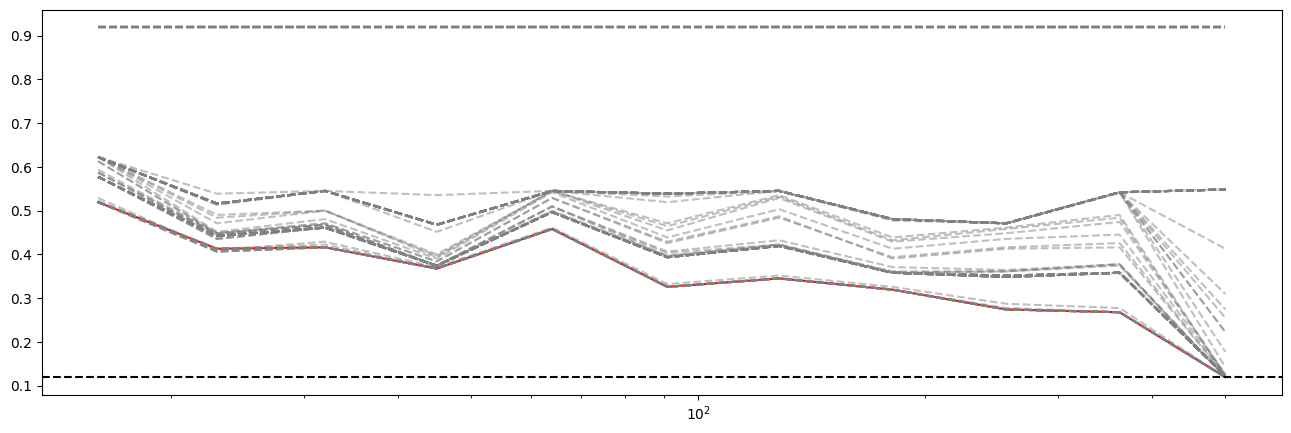

In [13]:
fig, ax = plt.subplots(figsize=(16, 5))
best_score = np.inf
for i, lc in enumerate(df["learning_curve"]):
    schedule = lc.anchors_size
    lc = lc.values[0, 1, :, :, :, :, -1] if lc.is_iteration_wise_curve else lc.values[0, 1] # validation error rate

    is_best = i == index_of_finally_best_config
    
    if np.any(~np.isnan(lc)):
        mu = np.nanmean(lc, axis=(0, 1, 2)).squeeze()
        std = np.nanstd(lc, axis=(0, 1, 2)).squeeze()
        ax.plot(schedule, mu, color="red" if is_best else "gray", linestyle="solid" if is_best else "--", alpha=1 if is_best else 0.5)
        #ax.fill_between(schedule, mu - std, mu + std, alpha=0.1)
        if not np.isnan(mu[-1]) and mu[-1] < best_score:
            best_score = mu[-1]
print(best_score)
ax.axhline(best_score, color="black", linestyle="--")
ax.set_xscale("log")
plt.show()

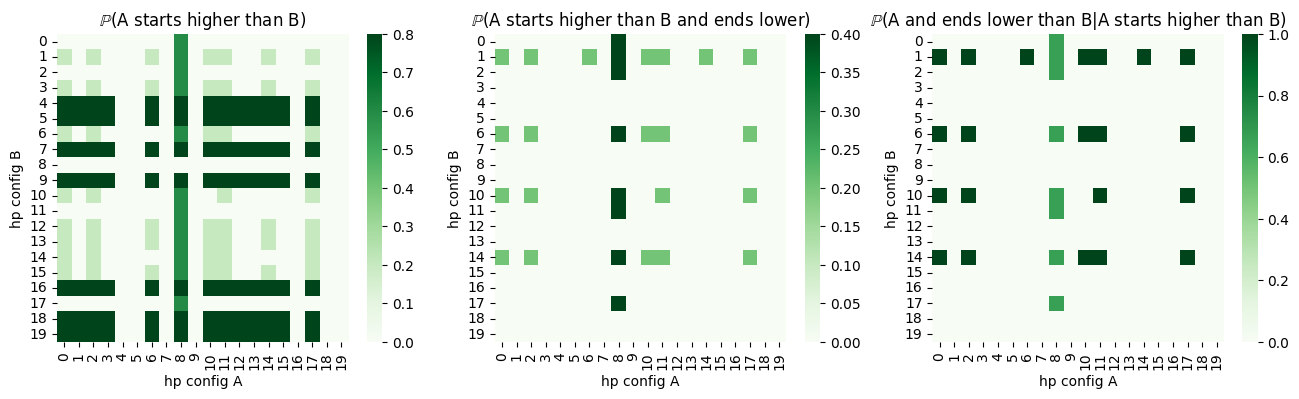

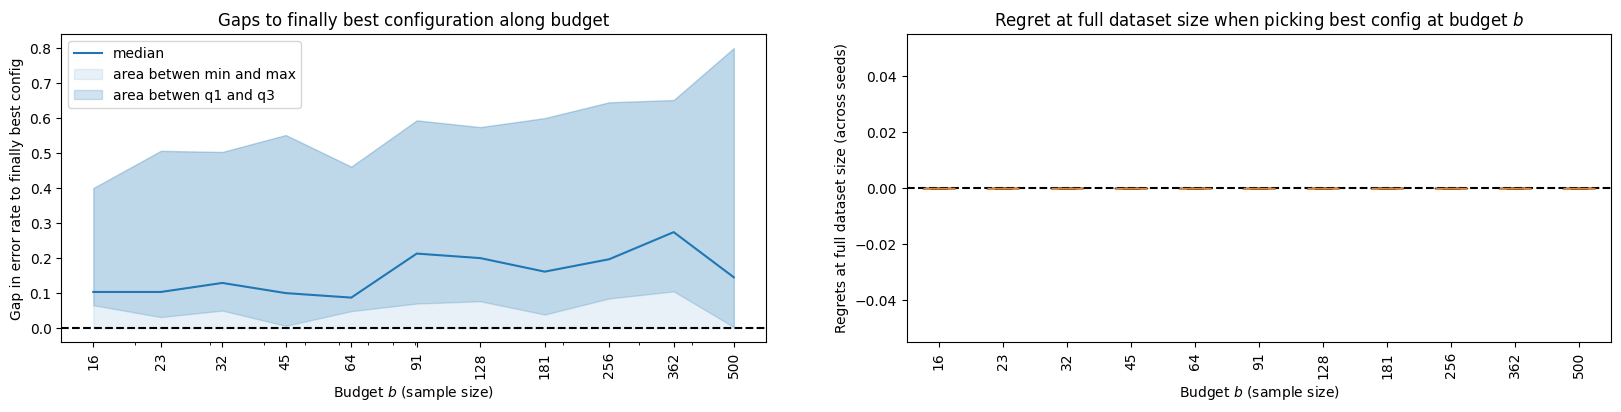

In [14]:
def learning_curve_crossing_evaluation(lcg):
    
    schedule = lcg.anchors_size
    
    # compute diffs at different anchors
    diffs = np.zeros((len(lcg), len(lcg), len(lcg.test_seeds), len(lcg.val_seeds), len(lcg.workflow_seeds), len(schedule)))
    for i, lc1 in enumerate(lcg):
        curve1 = lc1[0, 1]
        for j, lc2 in enumerate(lcg):
            curve2 = lc2[0, 1]
            diffs[i, j] = curve1 - curve2
    diffs_bin = diffs > 0
    
    # define start index
    start_index = 0
    
    # compute P(A starts lower than B)
    probs_a_starts_higher_than_b = diffs_bin[:,:,:,:,:,start_index].mean(axis=(2, 3, 4))
    
    # compute P(A starts lower than B and finishes higher)
    probs_a_strats_higher_than_b_and_ends_lower_than_b = (diffs_bin[:,:,:,:,:,start_index] & ~diffs_bin[:,:,:,:,:,-1]).mean(axis=(2, 3, 4))
    
    # figure for probability of crossing
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    sb.heatmap(probs_a_starts_higher_than_b, cmap="Greens", ax=axs[0])
    sb.heatmap(probs_a_strats_higher_than_b_and_ends_lower_than_b, cmap="Greens", ax=axs[1])
    sb.heatmap(probs_a_strats_higher_than_b_and_ends_lower_than_b / np.maximum(10**-10, probs_a_starts_higher_than_b), cmap="Greens", ax=axs[2])
    axs[0].set_title(r"$\mathbb{P}$(A starts higher than B)")
    axs[1].set_title(r"$\mathbb{P}$(A starts higher than B and ends lower)")
    axs[2].set_title(r"$\mathbb{P}$(A and ends lower than B|A starts higher than B)")
    for ax in axs:
        ax.set_xlabel("hp config A")
        ax.set_ylabel("hp config B")
    fig.savefig(f"plots/lc_crossing_{openmlid}_{workflow}.pdf", bbox_inches="tight")
    plt.show()
    
    # gaps to the finally best (at the respective budget)
    idx_of_best = np.argmin([np.nanmean(lc[0, 1, :, :, :, -1]) if np.count_nonzero(~np.isnan(lc[0, 1, :, :, :, -1])) > 0 else np.inf for lc in lcg])
    fig, axs = plt.subplots(1, 2, figsize=(20, 4))
    ax = axs[0]

    mean_diffs_per_config = diffs[:,idx_of_best].mean(axis=(1, 2, 3))
    q1 = np.nanpercentile(mean_diffs_per_config, 25, axis=0)
    q2 = np.nanmedian(mean_diffs_per_config, axis=0)
    q3 = np.nanpercentile(mean_diffs_per_config, 75, axis=0)
    ax.plot(schedule, q2, label="median")
    ax.fill_between(schedule, np.nanmin(mean_diffs_per_config, axis=0), np.nanmax(mean_diffs_per_config, axis=0), color="C0", alpha=0.1, label="area betwen min and max")
    ax.fill_between(schedule, q1, q3, color="C0", alpha=0.2, label="area betwen q1 and q3")

    #for row in mean_diffs_per_config[:5]:
     #   ax.plot(schedule, row, color="red")
    
    ax.axhline(0, color="black", linestyle="--")
    ax.set_title("Gaps to finally best configuration along budget")
    ax.set_xlabel("Budget $b$ (sample size)")
    ax.set_ylabel("Gap in error rate to finally best config")
    ax.set_xscale("log")
    ax.set_xticks(schedule)
    ax.set_xticklabels(schedule, rotation=90)
    ax.legend()
    
    # distribution of final gaps based on selections by budgets
    gaps_by_budget = {}
    for i, budget in enumerate(schedule):
        mean_scores_at_budget = []
        for lc in lcg:
            lc_slice = lc[0, 1, :, :, :, i]
            mean_scores_at_budget.append(np.nanmean(lc_slice) if np.count_nonzero(~np.isnan(lc_slice)) > 0 else np.inf)
        idx_of_best_at_budget = np.argmin(mean_scores_at_budget)
        gaps_by_budget[budget] = diffs[idx_of_best_at_budget,idx_of_best, :, :, :, -1].flatten()
        gaps_by_budget[budget] = gaps_by_budget[budget][~np.isnan(gaps_by_budget[budget])]
    ax = axs[1]
    ax.boxplot([gaps_by_budget[b] for b in schedule])
    ax.axhline(0, color="black", linestyle="--")
    ax.set_xticklabels(schedule, rotation=90)
    ax.set_title("Regret at full dataset size when picking best config at budget $b$")
    ax.set_xlabel("Budget $b$ (sample size)")
    ax.set_ylabel("Regrets at full dataset size (across seeds)")
    fig.savefig(f"plots/regrets_{openmlid}_{workflow}.pdf", bbox_inches="tight")
    plt.show()
    
    # figures for diffs
    if False:
        for i in range(len(schedule)):
            fig, ax = plt.subplots()
            sb.heatmap(diffs.mean(axis=(2, 3, 4))[:, :, i], ax=ax, vmin=-1, vmax=1, cmap="seismic")
            plt.show()
    
learning_curve_crossing_evaluation(lcg[:20])